In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Comparing MobileNet and Inception

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import logging

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Set logging level.
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0-rc1


In [3]:
# Setup dataset.
print('Download and split the dataset....')
split = tfds.Split.TRAIN.subsplit(weighted = (70, 30))
(dataset_training, dataset_validation), dataset_info = tfds.load(
  'tf_flowers',
  with_info = True,
  as_supervised = True,
  split = split
)
print('Preparing completed.')

Download and split the dataset....


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.
Preparing completed.


In [4]:
# Display info.
num_classes   = dataset_info.features['label'].num_classes
num_examples  = dataset_info.splits['train'].num_examples

# Verify by iterating the dataset.
num_image_training = 0
for i in dataset_training:
  num_image_training += 1

num_image_validation = 0
for i in dataset_validation:
  num_image_validation += 1

print('-- Total Summary --')
print('Total Classes:    {}'.format(num_classes))
print('Total Exmples:    {}'.format(num_examples))
print('Total Training:   {}'.format(num_image_training))
print('Total Validation: {}'.format(num_image_validation))

-- Total Summary --
Total Classes:    5
Total Exmples:    3670
Total Training:   2590
Total Validation: 1080


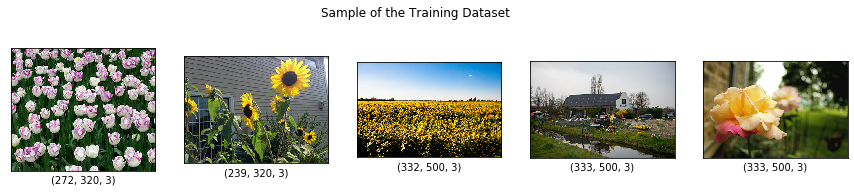

In [5]:
# Display some of the samples.
samples = dataset_training.take(5)
plt.figure(figsize = (15, 3))
for i, img in enumerate(samples):
  plt.subplot(1, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[0])
  plt.xlabel(img[0].shape)
_ = plt.suptitle('Sample of the Training Dataset')

In [6]:
# MobileNet: 224 x 224 with RGB
# Inception: 299 x 299 with RGB
BATCH_SIZE = 32

# Copy of the dataset.
print('Copy the datasets.')
dataset_test = dataset_validation.take(BATCH_SIZE)
mobilenet_dataset_training    = dataset_training
mobilenet_dataset_validation  = dataset_validation
mobilenet_dataset_test        = dataset_test
inception_dataset_training    = dataset_training
inception_dataset_validation  = dataset_validation
inception_dataset_test        = dataset_test

print('Resize Process....')

def resizeMobileNet(image, label):
  image = tf.image.resize(image, (224, 224)) / 255.0
  return image, label

def resizeInception(image, label):
  image = tf.image.resize(image, (299, 299)) / 255.0
  return image, label

mobilenet_batch_training    = mobilenet_dataset_training.shuffle(num_image_training//4).map(resizeMobileNet).batch(BATCH_SIZE).prefetch(1)
mobilenet_batch_validation  = mobilenet_dataset_validation.map(resizeMobileNet).batch(BATCH_SIZE).prefetch(1)
mobilenet_batch_test        = mobilenet_dataset_test.map(resizeMobileNet).batch(BATCH_SIZE).prefetch(1)
inception_batch_training    = inception_dataset_training.shuffle(num_image_training//4).map(resizeInception).batch(BATCH_SIZE).prefetch(1)
inception_batch_validation  = inception_dataset_validation.map(resizeInception).batch(BATCH_SIZE).prefetch(1)
inception_batch_test        = inception_dataset_test.map(resizeInception).batch(BATCH_SIZE).prefetch(1)
print('Resize Completed.')

Copy the datasets.
Resize Process....
Resize Completed.


In [0]:
# Build the model.
def buildModel(size, url, numClasses):
  feature_extractor = hub.KerasLayer(url, input_shape=(size, size, 3))

  # Freeze the extrator so we don't update its pretraing values.
  feature_extractor.trainable = False
  print('Freezing the extractor.')

  # Build our model to classify the flowers.
  model = tf.keras.Sequential()
  model.add(feature_extractor)
  model.add(tf.keras.layers.Dense(numClasses, activation='softmax'))

  model.summary()

  # Train the model.
  print('Compile the model.')
  model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [8]:
# Build models.
EPOCHS = 6
print('Total Epochs: {}'.format(EPOCHS))
print('--------------------------------------------')
print('-- MobileNet')
print('--------------------------------------------')
mobilenet = buildModel(
  224,
  'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
  num_classes
)

history_mobilenet = mobilenet.fit(
  mobilenet_batch_training,
  epochs=EPOCHS,
  validation_data = mobilenet_batch_validation
)
print('--------------------------------------------')


print('--------------------------------------------')
print('-- Inception')
print('--------------------------------------------')
inception = buildModel(
  299,
  'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4',
  num_classes
)

history_inception = inception.fit(
  inception_batch_training,
  epochs=EPOCHS,
  validation_data = inception_batch_validation
)
print('--------------------------------------------')

Total Epochs: 6
--------------------------------------------
-- MobileNet
--------------------------------------------
Freezing the extractor.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Compile the model.
Epoch 1/6
81/81 [==============================] - 15s 191ms/step - loss: 0.7769 - accuracy: 0.7251 - val_loss: 0.4782 - val_accuracy: 0.8278
Epoch 2/6
81/81 [==============================] - 7s 92ms/step - loss: 0.3698 - accuracy: 0.8807 - val_loss: 0.3911 - val_accuracy: 0.8620
Epoch 3/6
81/81 [==============================] - 7s 93ms/s

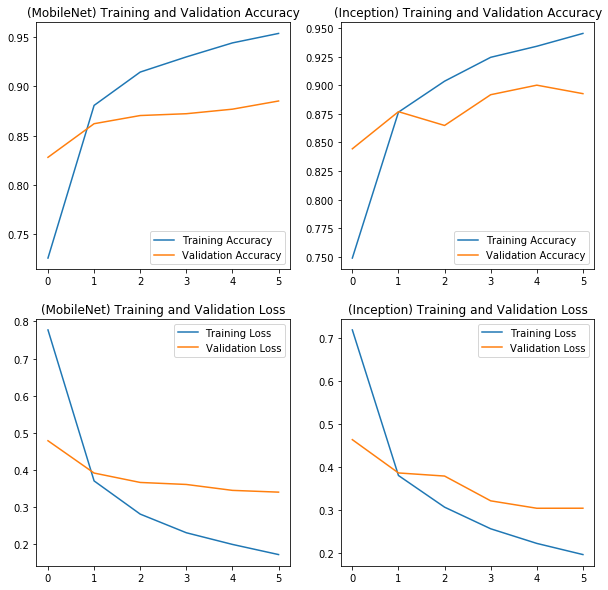

In [9]:
mobilenet_acc      = history_mobilenet.history['accuracy']
mobilenet_val_acc  = history_mobilenet.history['val_accuracy']
mobilenet_loss     = history_mobilenet.history['loss']
mobilenet_val_loss = history_mobilenet.history['val_loss']

inception_acc      = history_inception.history['accuracy']
inception_val_acc  = history_inception.history['val_accuracy']
inception_loss     = history_inception.history['loss']
inception_val_loss = history_inception.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, mobilenet_acc, label = 'Training Accuracy')
plt.plot(epochs_range, mobilenet_val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('(MobileNet) Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, inception_acc, label = 'Training Accuracy')
plt.plot(epochs_range, inception_val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('(Inception) Training and Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, mobilenet_loss, label = 'Training Loss')
plt.plot(epochs_range, mobilenet_val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('(MobileNet) Training and Validation Loss')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, inception_loss, label = 'Training Loss')
plt.plot(epochs_range, inception_val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('(Inception) Training and Validation Loss')

plt.show()

In [10]:
# Predict testing.
print('Predict some samples....')
class_names = np.array(dataset_info.features['label'].names)

mobilenet_batch_image, mobilenet_batch_label = next(iter(mobilenet_batch_test))
mobilenet_batch_image = mobilenet_batch_image.numpy()
mobilenet_batch_label = mobilenet_batch_label.numpy()

mobilenet_batch_predicted = mobilenet.predict(mobilenet_batch_image)
mobilenet_batch_predicted = tf.squeeze(mobilenet_batch_predicted).numpy()

mobilenet_predicted_ids     = np.argmax(mobilenet_batch_predicted, axis=-1)
mobilenet_predicted_classes = class_names[mobilenet_predicted_ids]

inception_batch_image, inception_batch_label = next(iter(inception_batch_test))
inception_batch_image = inception_batch_image.numpy()
inception_batch_label = inception_batch_label.numpy()

inception_batch_predicted = inception.predict(inception_batch_image)
inception_batch_predicted = tf.squeeze(inception_batch_predicted).numpy()

inception_predicted_ids     = np.argmax(inception_batch_predicted, axis=-1)
inception_predicted_classes = class_names[inception_predicted_ids]
print('Prediction completed!')

Predict some samples....
Prediction completed!


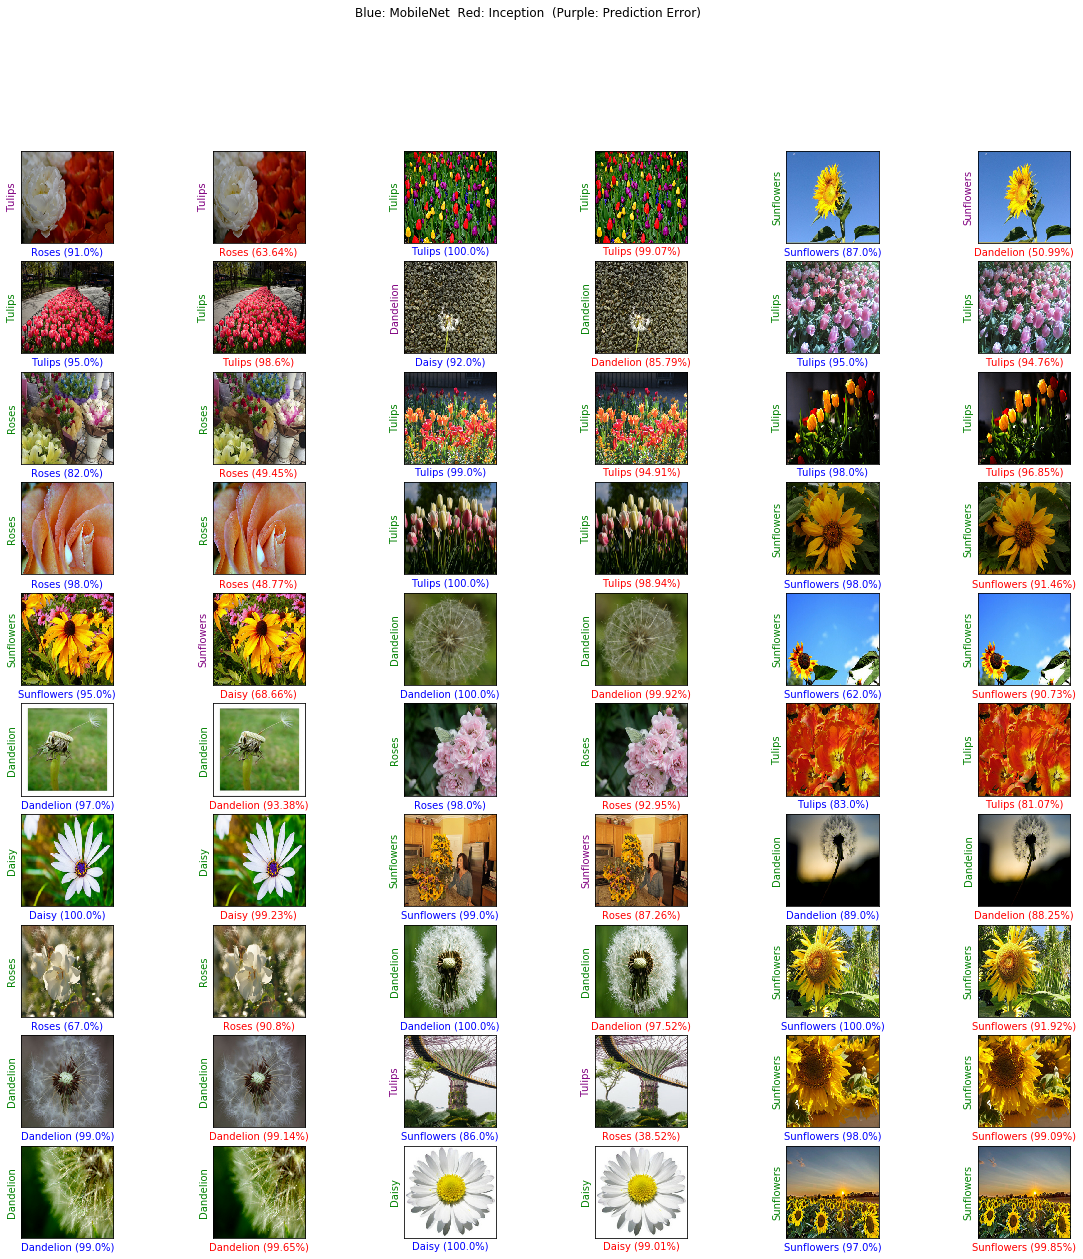

In [13]:
plt.figure(figsize=(20, 20))
for i in range(30):
  plt.subplot(10, 6, (i * 2) + 1)
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(mobilenet_batch_image[i])
  color = 'green' if mobilenet_predicted_ids[i] == mobilenet_batch_label[i] else 'purple'
  plt.xlabel('{} ({}%)'.format(mobilenet_predicted_classes[i].title(), round(100 * np.max(mobilenet_batch_predicted[i]))), color = 'blue')
  plt.ylabel(class_names[mobilenet_batch_label[i]].title(), color = color)

  plt.subplot(10, 6, (i * 2) + 2)
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(inception_batch_image[i])
  color = 'green' if inception_predicted_ids[i] == inception_batch_label[i] else 'purple'
  plt.xlabel('{} ({}%)'.format(inception_predicted_classes[i].title(), round(100 * np.max(inception_batch_predicted[i]), 2)), color = 'red')
  plt.ylabel(class_names[inception_batch_label[i]].title(), color = color)

_ = plt.suptitle("Blue: MobileNet  Red: Inception  (Purple: Prediction Error)")